## NETWORK INTRUSION DETECTION
###### Definition of Target and Outcome Window
       The task given is to build network intrusion detection system to detect anamolies and attacks in the network.
       There are two problems.
            1. Binomial Classification: Activity is normal or attack
            2. Multinomial classification: Activity is normal or DOS or PROBE or R2L or U2R
        Please note that, currently the dependent variable (target variable) is not definied explicitly.
        However, you can use attack variable to define the target variable as required.
###### Data Pre-Processing and Data Exploratory Analysis- 
    - Missing Values Check
    - Deriving new labels from attack labels (Binary and Muliclass)
    - Removing features with high percentage of zeros
    - Univariate Analysis - Outlier analysis
    - Creating dummy variables
    - Variable Reduction - VIF
###### Model Build and Model Evaluation
    - Train and Test split
    - Model used :- Random Forest Classifier, Logistic Regression, Gradient Boosting Classifier, Gradient Boosting Classifier,   
                    Decision Tree, ExtraTree Classifier   
    - Testing Parameters:- Accuracy, Precision, Recall, F1_score, classification report, confusion matrix
    * As our data has imbalanced labels, thus focusing on weighted F1_score
    - Scoring - cross val (weighted f1 score)

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.model_selection import cross_val_score

%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

#Models
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#Time Execution
!pip install ipython-autotime
%load_ext autotime

# Importing Dataset

In [2]:
# Reading the dataset
train_df = pd.read_csv("Train.txt",delimiter=',')
test_df = pd.read_csv("Test.txt",delimiter=',')

time: 1.23 s


In [3]:
# Providing column names to the datasets
col=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate",
"srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

train_df.columns = col

test_df.columns = col

time: 2.66 ms


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
duration                       125972 non-null int64
protocol_type                  125972 non-null object
service                        125972 non-null object
flag                           125972 non-null object
src_bytes                      125972 non-null int64
dst_bytes                      125972 non-null int64
land                           125972 non-null int64
wrong_fragment                 125972 non-null int64
urgent                         125972 non-null int64
hot                            125972 non-null int64
num_failed_logins              125972 non-null int64
logged_in                      125972 non-null int64
num_compromised                125972 non-null int64
root_shell                     125972 non-null int64
su_attempted                   125972 non-null int64
num_root                       125972 non-null int64
num_file_creations             125972 

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22543 entries, 0 to 22542
Data columns (total 43 columns):
duration                       22543 non-null int64
protocol_type                  22543 non-null object
service                        22543 non-null object
flag                           22543 non-null object
src_bytes                      22543 non-null int64
dst_bytes                      22543 non-null int64
land                           22543 non-null int64
wrong_fragment                 22543 non-null int64
urgent                         22543 non-null int64
hot                            22543 non-null int64
num_failed_logins              22543 non-null int64
logged_in                      22543 non-null int64
num_compromised                22543 non-null int64
root_shell                     22543 non-null int64
su_attempted                   22543 non-null int64
num_root                       22543 non-null int64
num_file_creations             22543 non-null int64
num_

# Data Preprocessing and EDA

In [6]:
#Analyzing the count of each attack in train dataset
train_df.attack.value_counts()

normal             67342
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: attack, dtype: int64

time: 47.1 ms


In [7]:
#Analyzing the count of each attack in test dataset
test_df.attack.value_counts()

normal             9711
neptune            4656
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
xterm                13
rootkit              13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
perl                  2
worm                  2
udpstorm              2
loadmodule            2
sqlattack             2
phf                   2
imap                  1
Name: attack, dtype: int64

time: 10.8 ms


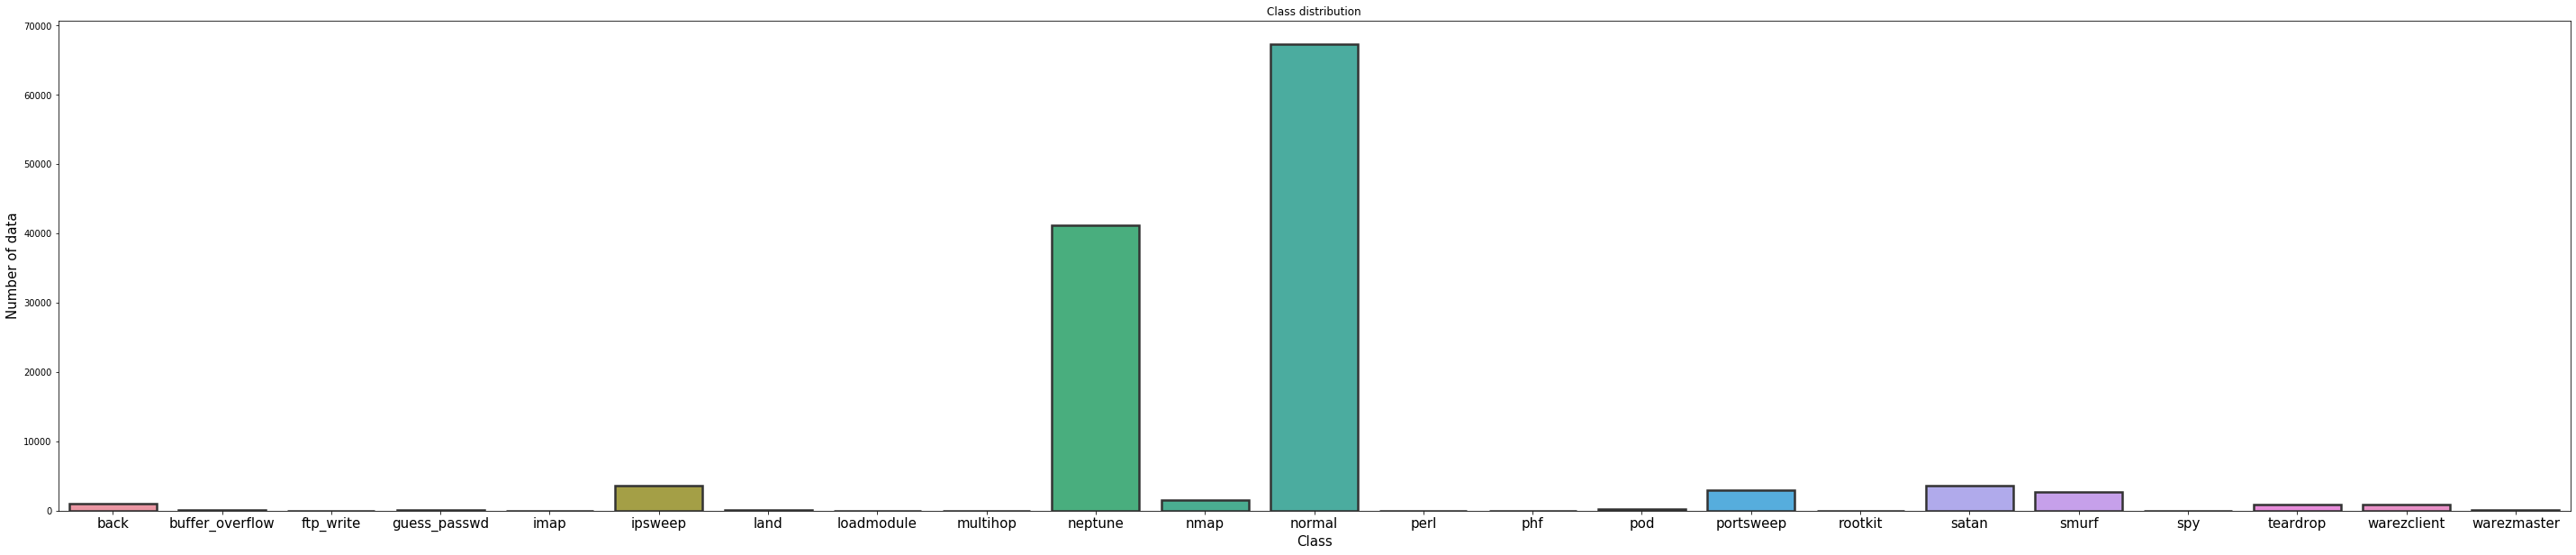

time: 1.49 s


In [8]:
#visualizing train attack values
label_count = train_df.groupby('attack', as_index = False).count()
class_name = list(label_count['attack'])
count = list(label_count['duration'])
index = np.arange(len(class_name))
plt.figure(figsize=(50,10))
sb.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15)
plt.title('Class distribution')
plt.show()

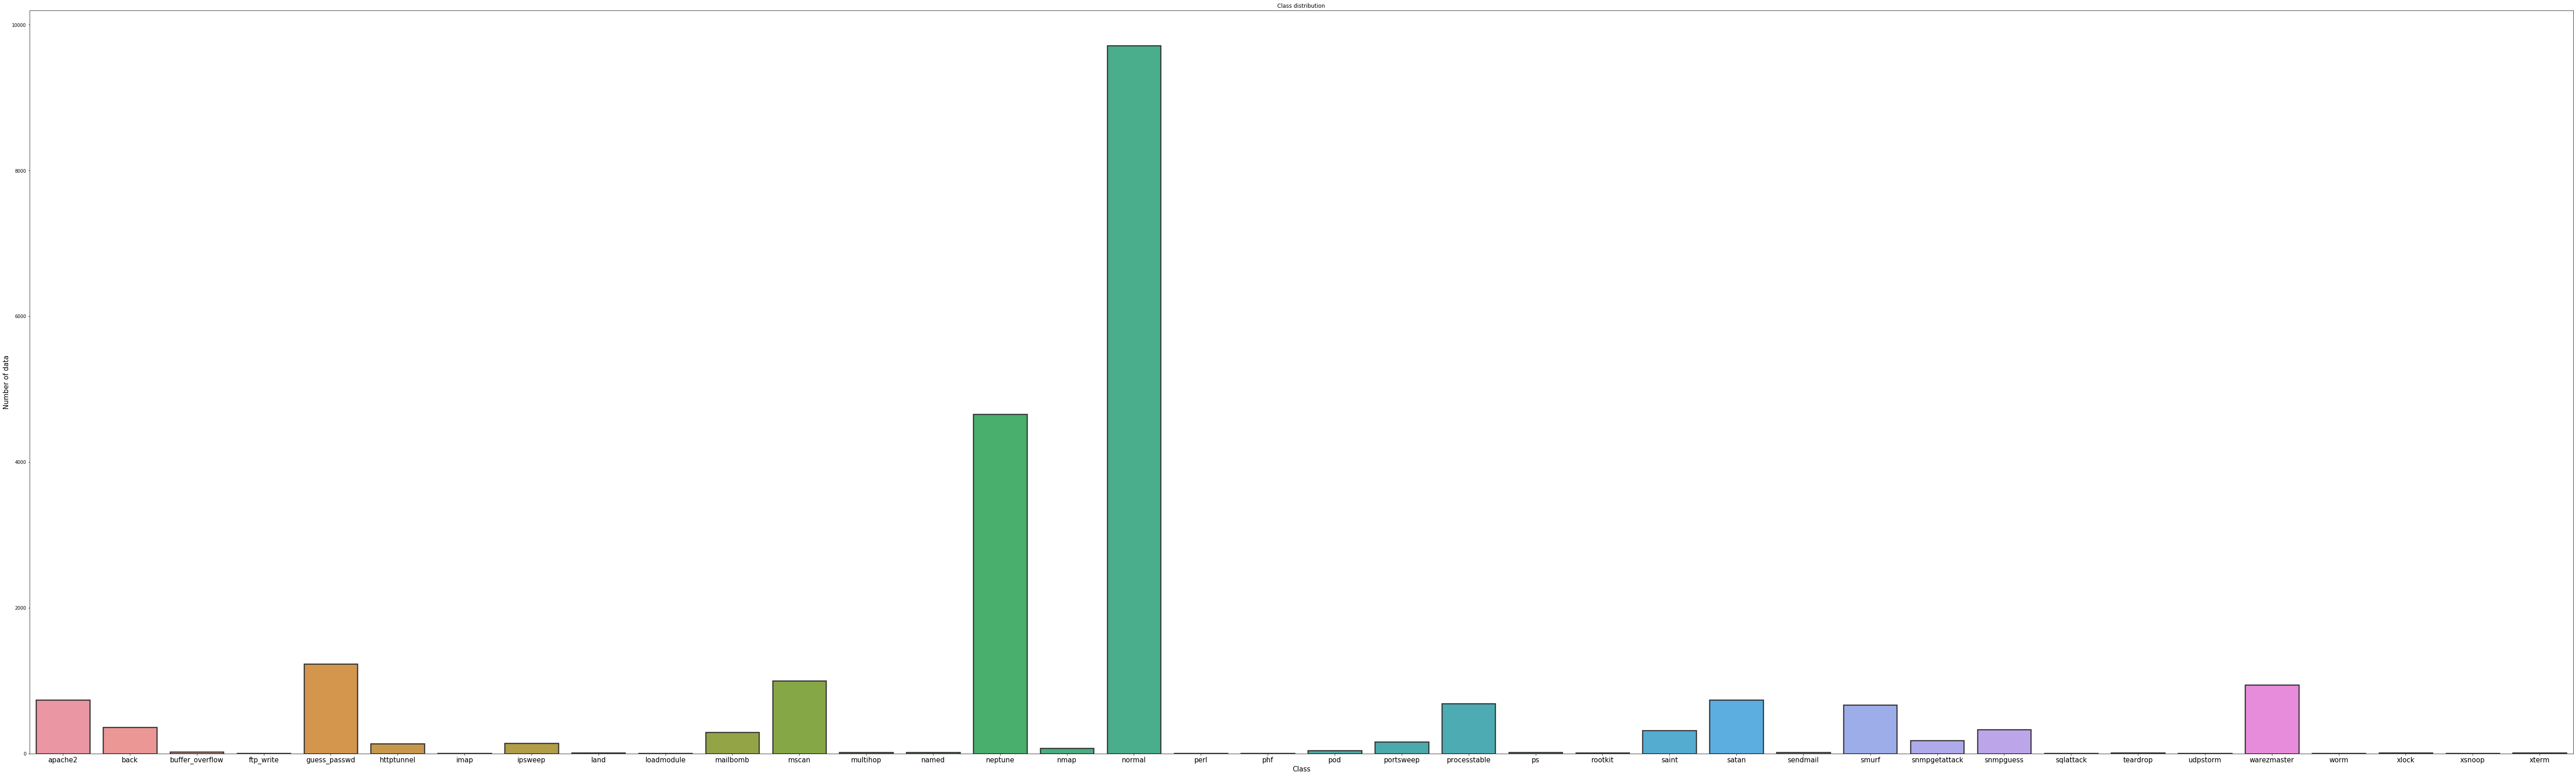

time: 3.9 s


In [9]:
#visualizing test attack values
label_count = test_df.groupby('attack', as_index = False).count()
class_name = list(label_count['attack'])
count = list(label_count['duration'])
index = np.arange(len(class_name))
plt.figure(figsize=(100,30))
sb.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15)
plt.title('Class distribution')
plt.show()

Test data has more variants of attack then train. This is an imbalance dataset

## Missing value 

In [10]:
#Checking if there are any missing values in train dataset
train_df.isna().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

time: 88.4 ms


In [11]:
#Checking if there are any missing values in test dataset
test_df.isna().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

time: 21.1 ms


## Deriving binary and multiclass labels from attack label. 

In [12]:
#Creating new column for attack or no attack.
attack_mapping_binomial = {"normal":0,"back":1,"land":1,"neptune":1,"pod":1,"smurf":1,"teardrop":1,"apache2":1,"udpstorm":1,"processtable":1,"worm":1,
                           "mailbomb":1,"satan":1,"ipsweep":1,"nmap":1,"portsweep":1,"mscan":1,"saint":1,"guess_passwd":1,"ftp_write":1,"imap":1,"phf":1,"multihop":1,
                           "warezmaster":1,"warezclient":1,"spy":1,"xlock":1,"xsnoop":1,"snmpguess":1,"snmpgetattack":1,"httptunnel":1,"sendmail":1,"named":1,
                           "buffer_overflow":1,"loadmodule":1,"rootkit":1,"perl":1,"sqlattack":1,"xterm":1,"ps":1}

train_df['bi_attack'] = train_df['attack'].map(attack_mapping_binomial)
test_df['bi_attack'] = test_df['attack'].map(attack_mapping_binomial)

#Creating new mulitnomial column as one of the 4 major categories of attack [DOS, PROBE, R2L, U2R]
attack_mapping_multinomial = {"normal":'normal',
                           "back":"Dos","land":"Dos","neptune":"Dos","pod":"Dos","smurf":"Dos","teardrop":"Dos","apache2":"Dos","udpstorm":"Dos","processtable":"Dos",
                           "worm":"Dos", "mailbomb":"Dos",
                           "satan":"Probe","ipsweep":"Probe","nmap":"Probe","portsweep":"Probe","mscan":"Probe","saint":"Probe",
                           "guess_passwd":"R2L","ftp_write":"R2L","imap":"R2L","phf":"R2L","multihop":"R2L","warezmaster":"R2L","warezclient":"R2L","spy":"R2L",
                           "xlock":"R2L","xsnoop":"R2L","snmpguess":"R2L","snmpgetattack":"R2L","httptunnel":"R2L","sendmail":"R2L","named":"R2L",
                           "buffer_overflow":"U2R","loadmodule":"U2R","rootkit":"U2R","perl":"U2R","sqlattack":"U2R","xterm":"U2R","ps":"U2R"}

train_df['multi_attack'] = train_df['attack'].map(attack_mapping_multinomial)
test_df['multi_attack'] = test_df['attack'].map(attack_mapping_multinomial)

time: 63 ms


In [13]:
#Checking newly created labels in train dataset
train_df[['bi_attack','multi_attack']]

,bi_attack,multi_attack
0,0,normal
1,1,Dos
2,0,normal
3,0,normal
4,1,Dos
...,...,...
125967,1,Dos
125968,0,normal
125969,0,normal
125970,1,Dos


time: 100 ms


In [14]:
#Checking newly created labels in test dataset
test_df[['bi_attack','multi_attack']]

,bi_attack,multi_attack
0,1,Dos
1,0,normal
2,1,Probe
3,1,Probe
4,0,normal
...,...,...
22538,0,normal
22539,0,normal
22540,1,Dos
22541,0,normal


time: 29.4 ms


In [15]:
train_df.bi_attack.value_counts()

0    67342
1    58630
Name: bi_attack, dtype: int64

time: 14.8 ms


In [16]:
test_df.bi_attack.value_counts()

1    12832
0     9711
Name: bi_attack, dtype: int64

time: 9.67 ms


In [17]:
train_df.multi_attack.value_counts()

normal    67342
Dos       45927
Probe     11656
R2L         995
U2R          52
Name: multi_attack, dtype: int64

time: 25.6 ms


In [18]:
test_df.multi_attack.value_counts()

normal    9711
Dos       7459
R2L       2885
Probe     2421
U2R         67
Name: multi_attack, dtype: int64

time: 14.5 ms


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 45 columns):
duration                       125972 non-null int64
protocol_type                  125972 non-null object
service                        125972 non-null object
flag                           125972 non-null object
src_bytes                      125972 non-null int64
dst_bytes                      125972 non-null int64
land                           125972 non-null int64
wrong_fragment                 125972 non-null int64
urgent                         125972 non-null int64
hot                            125972 non-null int64
num_failed_logins              125972 non-null int64
logged_in                      125972 non-null int64
num_compromised                125972 non-null int64
root_shell                     125972 non-null int64
su_attempted                   125972 non-null int64
num_root                       125972 non-null int64
num_file_creations             125972 

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22543 entries, 0 to 22542
Data columns (total 45 columns):
duration                       22543 non-null int64
protocol_type                  22543 non-null object
service                        22543 non-null object
flag                           22543 non-null object
src_bytes                      22543 non-null int64
dst_bytes                      22543 non-null int64
land                           22543 non-null int64
wrong_fragment                 22543 non-null int64
urgent                         22543 non-null int64
hot                            22543 non-null int64
num_failed_logins              22543 non-null int64
logged_in                      22543 non-null int64
num_compromised                22543 non-null int64
root_shell                     22543 non-null int64
su_attempted                   22543 non-null int64
num_root                       22543 non-null int64
num_file_creations             22543 non-null int64
num_

## Splitting num and cat from train and test

In [21]:
#List for binary categorical features
bi_cat_list = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login','is_guest_login']
#List for mulicategorical features
multi_cat_list = ['protocol_type', 'service', 'flag']
#List for binary and multi categorical features
combo_cat_list = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login','is_guest_login','protocol_type', 'service', 'flag','attack','bi_attack','multi_attack']

time: 1.1 ms


### Numerical

In [22]:
#Function for detail audit report
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])



time: 7.28 ms


In [23]:
#Audit report for train dataset
train_df[train_df.columns.difference(combo_cat_list)].apply(lambda x: var_summary(x)).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
count,125972.0,0.0,1.059528e+07,84.108207,14.00,1.145088e+02,1.311227e+04,0.0,1.0,1.00,1.00,2.00,14.00,143.00,256.00,286.00,511.00,5.110000e+02
diff_srv_rate,125972.0,0.0,7.942930e+03,0.063053,0.00,1.803150e-01,3.251351e-02,0.0,0.0,0.00,0.00,0.00,0.00,0.06,0.07,0.29,1.00,1.000000e+00
dst_bytes,125972.0,0.0,2.491634e+09,19779.271433,0.00,4.021285e+06,1.617073e+13,0.0,0.0,0.00,0.00,0.00,0.00,516.00,3375.90,8314.00,25519.00,1.309937e+09
dst_host_count,125972.0,0.0,2.294570e+07,182.149200,255.00,9.920657e+01,9.841943e+03,0.0,1.0,3.00,11.00,82.00,255.00,255.00,255.00,255.00,255.00,2.550000e+02
dst_host_diff_srv_rate,125972.0,0.0,1.044957e+04,0.082952,0.02,1.889225e-01,3.569171e-02,0.0,0.0,0.00,0.00,0.00,0.02,0.07,0.10,0.56,1.00,1.000000e+00
dst_host_rerror_rate,125972.0,0.0,1.496955e+04,0.118832,0.00,3.065586e-01,9.397818e-02,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.84,1.00,1.00,1.000000e+00
dst_host_same_src_port_rate,125972.0,0.0,1.869156e+04,0.148379,0.00,3.089984e-01,9.547998e-02,0.0,0.0,0.00,0.00,0.00,0.00,0.06,0.84,1.00,1.00,1.000000e+00
dst_host_same_srv_rate,125972.0,0.0,6.566221e+04,0.521244,0.51,4.489501e-01,2.015562e-01,0.0,0.0,0.00,0.01,0.05,0.51,1.00,1.00,1.00,1.00,1.000000e+00
dst_host_serror_rate,125972.0,0.0,3.583333e+04,0.284455,0.00,4.447851e-01,1.978338e-01,0.0,0.0,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.000000e+00
dst_host_srv_count,125972.0,0.0,1.456913e+07,115.653725,63.00,1.107029e+02,1.225513e+04,0.0,1.0,1.00,2.00,10.00,63.00,255.00,255.00,255.00,255.00,2.550000e+02


time: 2.94 s


In [24]:
#Audit report for test dataset
test_df[test_df.columns.difference(combo_cat_list)].apply(lambda x: var_summary(x)).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
count,22543.0,0.0,1.781386e+06,79.021692,8.00,128.538218,1.652207e+04,0.0,1.0,1.00,1.00,1.00,8.00,123.00,256.00,400.90,511.0000,511.0
diff_srv_rate,22543.0,0.0,2.120740e+03,0.094075,0.00,0.259143,6.715523e-02,0.0,0.0,0.00,0.00,0.00,0.00,0.06,0.09,1.00,1.0000,1.0
dst_bytes,22543.0,0.0,4.635089e+07,2056.110012,46.00,21219.763847,4.502784e+08,0.0,0.0,0.00,0.00,0.00,46.00,601.00,4099.40,8314.00,26032.7600,1345927.0
dst_host_count,22543.0,0.0,4.370337e+06,193.866699,255.00,94.036867,8.842932e+03,0.0,1.0,6.00,20.00,121.00,255.00,255.00,255.00,255.00,255.0000,255.0
dst_host_diff_srv_rate,22543.0,0.0,2.041070e+03,0.090541,0.01,0.220722,4.871805e-02,0.0,0.0,0.00,0.00,0.00,0.01,0.06,0.15,0.75,1.0000,1.0
dst_host_rerror_rate,22543.0,0.0,5.260430e+03,0.233351,0.00,0.387204,1.499267e-01,0.0,0.0,0.00,0.00,0.00,0.00,0.36,1.00,1.00,1.0000,1.0
dst_host_same_src_port_rate,22543.0,0.0,2.981690e+03,0.132267,0.00,0.306274,9.380364e-02,0.0,0.0,0.00,0.00,0.00,0.00,0.03,0.85,1.00,1.0000,1.0
dst_host_same_srv_rate,22543.0,0.0,1.372298e+04,0.608747,0.92,0.435681,1.898182e-01,0.0,0.0,0.00,0.02,0.07,0.92,1.00,1.00,1.00,1.0000,1.0
dst_host_serror_rate,22543.0,0.0,2.205110e+03,0.097818,0.00,0.273144,7.460766e-02,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.35,1.00,1.0000,1.0
dst_host_srv_count,22543.0,0.0,3.173070e+06,140.756332,168.00,111.783059,1.249545e+04,0.0,1.0,1.00,3.00,15.00,168.00,255.00,255.00,255.00,255.0000,255.0


time: 1.01 s


In [25]:
#segregating numerical attributes
train_short = (train_df[train_df.columns.difference(combo_cat_list)])
test_short = (test_df[test_df.columns.difference(combo_cat_list)])

time: 49.4 ms


#### Removing attributes with high percentage of zeros

In [26]:
#Function to remove features with more than 25% of zeros
def zero_count(data):
    train_zero_count = data[data == 0].count(axis=0)/len(data.index)
    train_zero_count = train_zero_count.reset_index()
    train_zero_count.columns = ['col','zero']
    train_zero_count = train_zero_count.drop(index=0).reset_index(drop=True)
    print(train_zero_count)
    print('Removing columns with zero % of more than 25%')
    train_zero_count2 = train_zero_count[train_zero_count['zero'] > 0.25]
    data = data.drop(columns=data[train_zero_count2['col']])
    print(data.info())
    return data

time: 4.75 ms


In [27]:
train_short = zero_count(train_short)
test_short = zero_count(test_short)

                            col      zero
0                 diff_srv_rate  0.605023
1                     dst_bytes  0.539533
2                dst_host_count  0.000024
3        dst_host_diff_srv_rate  0.373011
4          dst_host_rerror_rate  0.819055
5   dst_host_same_src_port_rate  0.500294
6        dst_host_same_srv_rate  0.054988
7          dst_host_serror_rate  0.646056
8            dst_host_srv_count  0.000024
9   dst_host_srv_diff_host_rate  0.689860
10     dst_host_srv_rerror_rate  0.846339
11     dst_host_srv_serror_rate  0.677603
12                     duration  0.920474
13                          hot  0.978797
14                    last_flag  0.000524
15             num_access_files  0.997055
16              num_compromised  0.989791
17            num_failed_logins  0.999032
18           num_file_creations  0.997722
19            num_outbound_cmds  1.000000
20                     num_root  0.994848
21                   num_shells  0.999627
22                  rerror_rate  0

Successfully reduced number of numerical columns from 32 to 7

#### Outlier Analysis

In [28]:
#Function to plot dist plot and box plot
def num_plot(columns,train,test):
    for i in columns:
        plt.figure(figsize=(20,20))
        plt.subplot(4,4,1)
        sb.distplot(train[i])
        plt.title(str('Subplot for train:- ') + str(i))
        plt.subplot(4,4,2)
        plt.boxplot(train[i])
        plt.title(str('Boxplot for train:- ') + str(i))
        plt.subplot(4,4,3)
        sb.distplot(test[i])
        plt.title(str('Subplot for test:- ') + str(i))
        plt.subplot(4,4,4)
        plt.boxplot(test[i])
        plt.title(str('Boxplot for test:- ') + str(i))

time: 6.98 ms


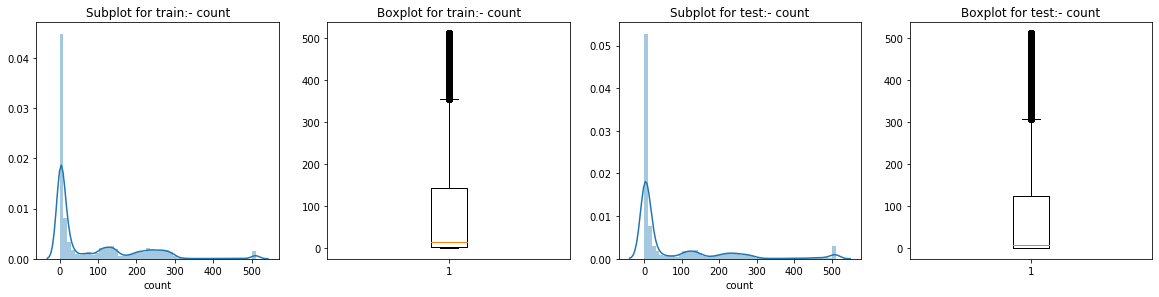

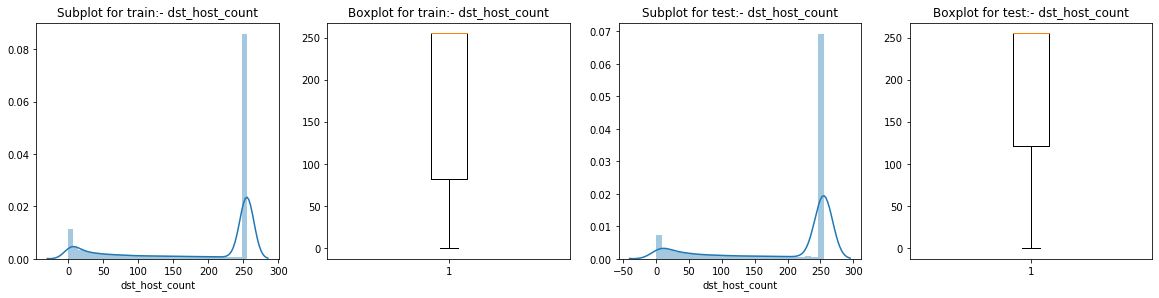

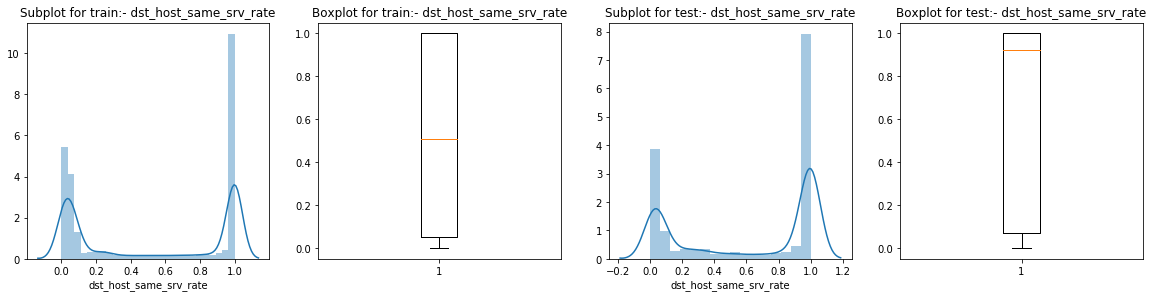

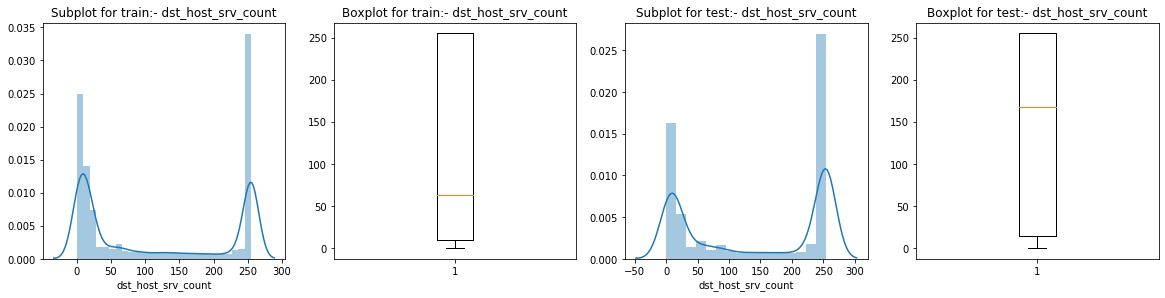

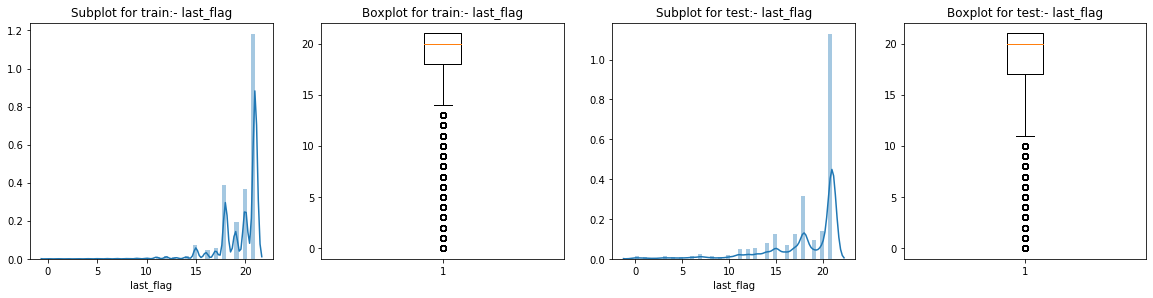

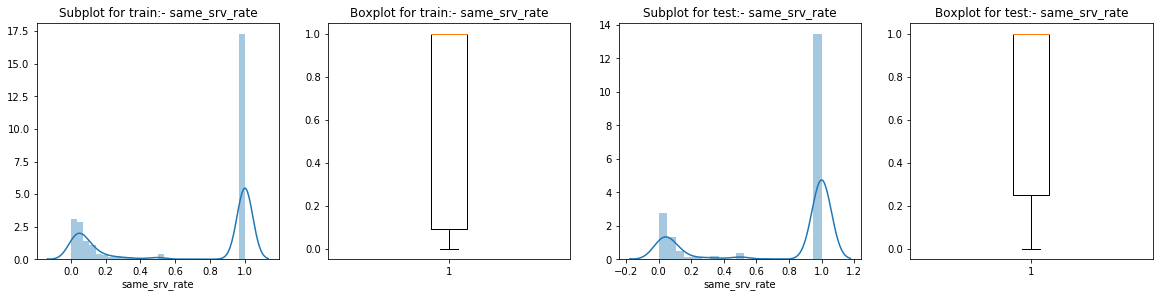

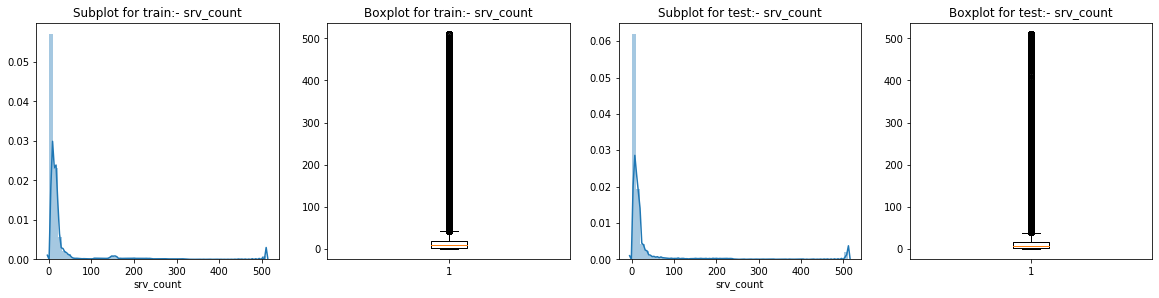

time: 12.2 s


In [29]:
num_plot((train_short.columns),train_short,test_short)

In [30]:
#Function to clip outliers at 5% and 95%
def outlier_capping(x):
    x = x.clip(x.quantile(0.95))
    x = x.clip(x.quantile(0.05))
    return x

time: 2.06 ms


In [31]:
train_short_clip=train_short.apply(lambda x: outlier_capping(x))
test_short_clip=test_short.apply(lambda x: outlier_capping(x))

time: 345 ms


C:\Users\chord\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\chord\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\chord\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\chord\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\chord\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\chord\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data

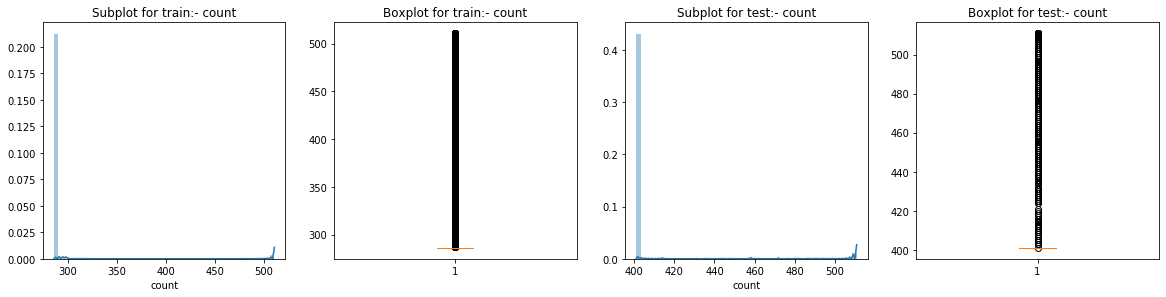

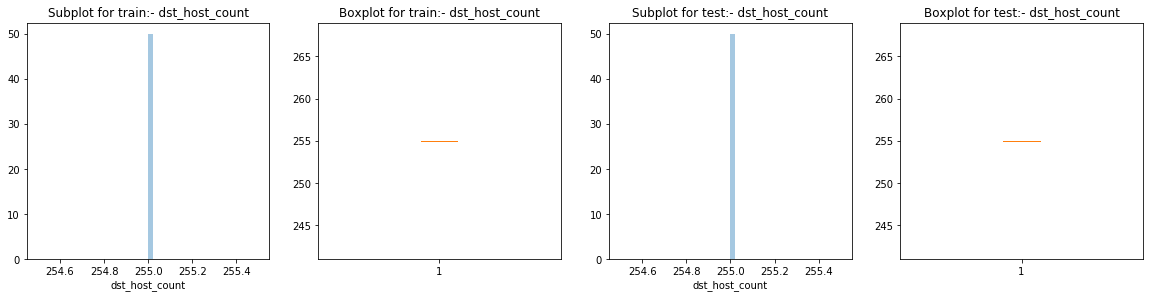

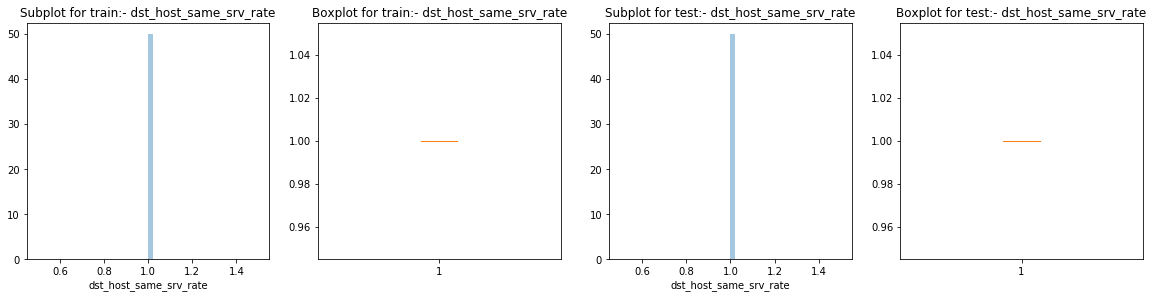

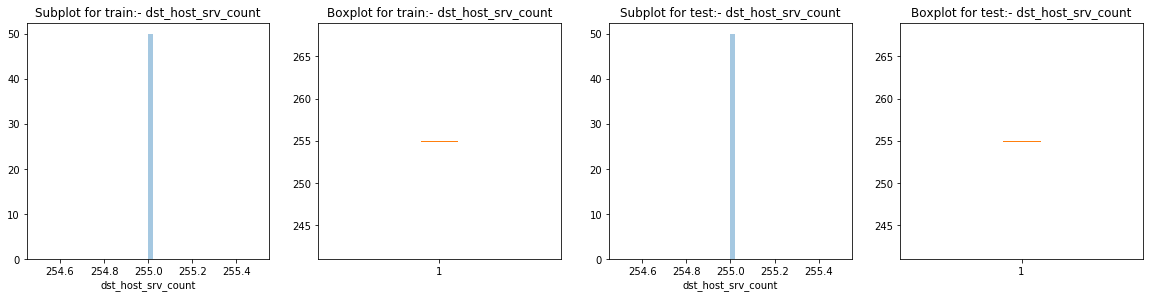

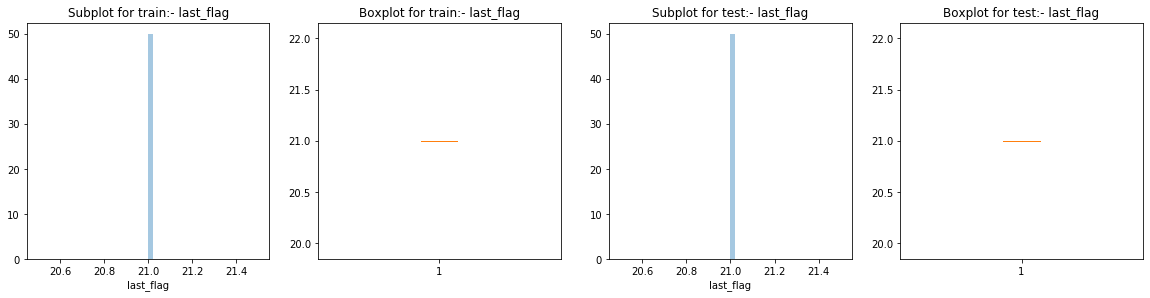

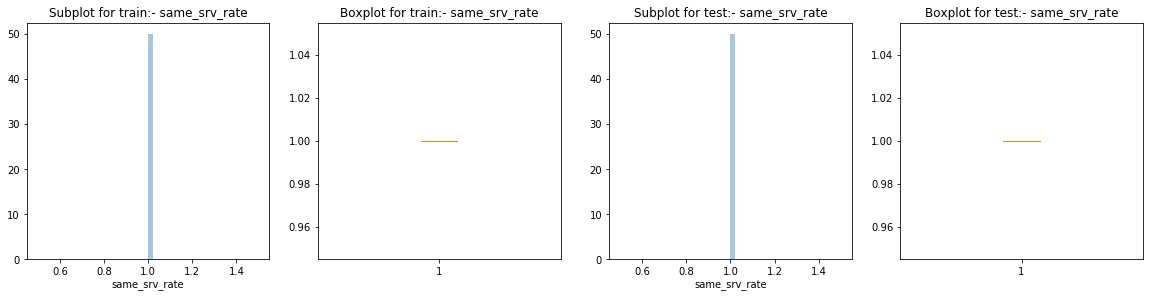

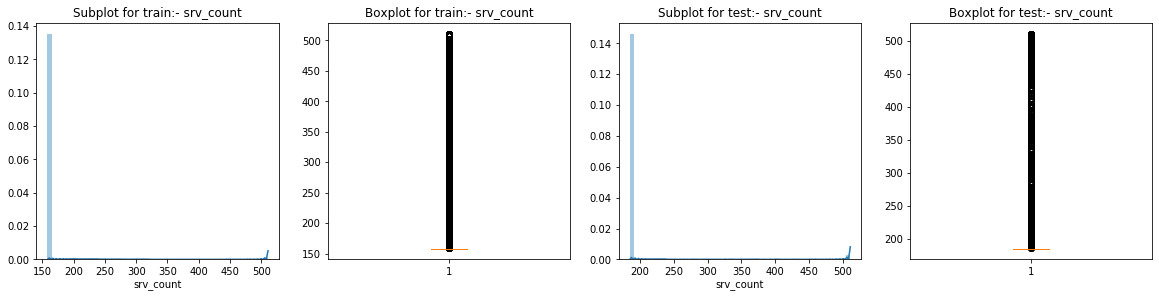

time: 11.8 s


In [32]:
num_plot((train_short_clip.columns),train_short_clip,test_short_clip)

        It seems that due to clipping the variance in the dataset is being lost. Hence will 

### Categorical 

#### Creating dummy variables for train and test categories

In [33]:
#train
#Extracting a list of column names
train_cat = pd.get_dummies(train_df[multi_cat_list], prefix = multi_cat_list,columns=multi_cat_list)
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 84 columns):
protocol_type_icmp     125972 non-null uint8
protocol_type_tcp      125972 non-null uint8
protocol_type_udp      125972 non-null uint8
service_IRC            125972 non-null uint8
service_X11            125972 non-null uint8
service_Z39_50         125972 non-null uint8
service_aol            125972 non-null uint8
service_auth           125972 non-null uint8
service_bgp            125972 non-null uint8
service_courier        125972 non-null uint8
service_csnet_ns       125972 non-null uint8
service_ctf            125972 non-null uint8
service_daytime        125972 non-null uint8
service_discard        125972 non-null uint8
service_domain         125972 non-null uint8
service_domain_u       125972 non-null uint8
service_echo           125972 non-null uint8
service_eco_i          125972 non-null uint8
service_ecr_i          125972 non-null uint8
service_efs            125972 non-

In [34]:
#test
#Extracting a list of column names
test_cat = pd.get_dummies(test_df[multi_cat_list], prefix=multi_cat_list,columns=multi_cat_list)
test_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22543 entries, 0 to 22542
Data columns (total 78 columns):
protocol_type_icmp     22543 non-null uint8
protocol_type_tcp      22543 non-null uint8
protocol_type_udp      22543 non-null uint8
service_IRC            22543 non-null uint8
service_X11            22543 non-null uint8
service_Z39_50         22543 non-null uint8
service_auth           22543 non-null uint8
service_bgp            22543 non-null uint8
service_courier        22543 non-null uint8
service_csnet_ns       22543 non-null uint8
service_ctf            22543 non-null uint8
service_daytime        22543 non-null uint8
service_discard        22543 non-null uint8
service_domain         22543 non-null uint8
service_domain_u       22543 non-null uint8
service_echo           22543 non-null uint8
service_eco_i          22543 non-null uint8
service_ecr_i          22543 non-null uint8
service_efs            22543 non-null uint8
service_exec           22543 non-null uint8
service_fin

#### Extra Columns

In [35]:
#Detecting columns difference between train and test
train_cat.columns.difference(test_cat.columns)

Index(['service_aol', 'service_harvest', 'service_http_2784',
       'service_http_8001', 'service_red_i', 'service_urh_i'],
      dtype='object')

time: 10.1 ms


In [36]:
test_cat.columns.difference(train_cat.columns)

Index([], dtype='object')

time: 6.98 ms


In [37]:
#To stablize both datasets extra columns present in train dataset are being deleted
train_cat.drop(columns = train_cat.columns.difference(test_cat.columns),inplace=True)

time: 47 ms


### Combining The Dataset

In [38]:
train_combine = pd.concat([train_short,train_cat,train_df[['bi_attack','multi_attack']]],axis=1)
test_combine = pd.concat([test_short,test_cat,test_df[['bi_attack','multi_attack']]],axis=1)

time: 41 ms


In [39]:
train_combine

,count,dst_host_count,dst_host_same_srv_rate,dst_host_srv_count,last_flag,same_srv_rate,srv_count,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,bi_attack,multi_attack
0,13,255,0.00,1,15,0.08,1,0,0,1,...,0,0,0,0,0,0,1,0,0,normal
1,123,255,0.10,26,19,0.05,6,0,1,0,...,0,0,1,0,0,0,0,0,1,Dos
2,5,30,1.00,255,21,1.00,5,0,1,0,...,0,0,0,0,0,0,1,0,0,normal
3,30,255,1.00,255,21,1.00,32,0,1,0,...,0,0,0,0,0,0,1,0,0,normal
4,121,255,0.07,19,21,0.16,19,0,1,0,...,0,0,0,0,0,0,0,0,1,Dos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,184,255,0.10,25,20,0.14,25,0,1,0,...,0,0,1,0,0,0,0,0,1,Dos
125968,2,255,0.96,244,21,1.00,2,0,0,1,...,0,0,0,0,0,0,1,0,0,normal
125969,1,255,0.12,30,18,1.00,1,0,1,0,...,0,0,0,0,0,0,1,0,0,normal
125970,144,255,0.03,8,20,0.06,8,0,1,0,...,0,0,1,0,0,0,0,0,1,Dos


time: 260 ms


## Feature Engineering

### VIF

In [40]:
c_drop = ['flag_S0','protocol_type_tcp','protocol_type_icmp','last_flag','same_srv_rate','dst_host_same_srv_rate','flag_SF','dst_host_srv_count']
c_vif_data = train_combine[train_combine.columns.difference(['attack','bi_attack','multi_attack'])].drop(c_drop,axis=1)
c_vif = pd.DataFrame()
c_vif["VIF Factor"] = [variance_inflation_factor(c_vif_data.values, i) for i in range(c_vif_data.shape[1])]
c_vif["features"] = c_vif_data.columns
c_vif.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
1,7.386502,dst_host_count
0,5.646934,count
11,5.210832,protocol_type_udp
23,4.965236,service_domain_u
76,4.573707,srv_count
...,...,...
13,1.002272,service_X11
9,1.001707,flag_S3
68,1.001158,service_tftp_u
53,1.000307,service_pm_dump


time: 3min 1s


In [41]:
#Features not present in final vif list are removed from train and test dataset.
train_combine_vif = train_combine[(c_vif.features)]
test_combine_vif = test_combine[(c_vif.features)]

time: 52.2 ms


In [42]:
#Binary and multi_attack lables are added to the final dataset
train_combine_vif = pd.concat([train_combine_vif, train_df[['bi_attack','multi_attack']]],axis=1)
test_combine_vif = pd.concat([test_combine_vif, test_df[['bi_attack','multi_attack']]],axis=1)

time: 33 ms


In [43]:
train_combine_vif.info()
test_combine_vif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 79 columns):
count                  125972 non-null int64
dst_host_count         125972 non-null int64
flag_OTH               125972 non-null uint8
flag_REJ               125972 non-null uint8
flag_RSTO              125972 non-null uint8
flag_RSTOS0            125972 non-null uint8
flag_RSTR              125972 non-null uint8
flag_S1                125972 non-null uint8
flag_S2                125972 non-null uint8
flag_S3                125972 non-null uint8
flag_SH                125972 non-null uint8
protocol_type_udp      125972 non-null uint8
service_IRC            125972 non-null uint8
service_X11            125972 non-null uint8
service_Z39_50         125972 non-null uint8
service_auth           125972 non-null uint8
service_bgp            125972 non-null uint8
service_courier        125972 non-null uint8
service_csnet_ns       125972 non-null uint8
service_ctf            125972 non-

## Split Independent and Target in Train and Test

In [44]:
#split binomial
def split(data,dependent):
    features_log = data.columns.difference([str(dependent)])
    feat_log = data[features_log]
    pre_log = data[str(dependent)].copy()
    return feat_log, pre_log

time: 2.08 ms


In [45]:
bi_train_x_vif, bi_train_y_vif = split(train_combine_vif[train_combine_vif.columns.difference(['multi_attack','attack'])],'bi_attack')
bi_test_x_vif, bi_test_y_vif = split(test_combine_vif[test_combine_vif.columns.difference(['multi_attack','attack'])],'bi_attack')
multi_train_x_vif, multi_train_y_vif = split(train_combine_vif[train_combine_vif.columns.difference(['bi_attack','attack'])],'multi_attack')
multi_test_x_vif, multi_test_y_vif = split(test_combine_vif[test_combine_vif.columns.difference(['bi_attack','attack'])],'multi_attack')

time: 207 ms


## Model Build and Evaluation

In [46]:
# Function to build and evaluate other models
def model_build_cum_evaluation(model,x,y,x_t,y_t,m_x,m_y,m_x_t,m_y_t):
    
    print('Binary Classification')
    #Fitting model binary
    model.fit(x,y)
    
    #Predicting values for train_x and test_x
    model_train_predict = model.predict(x)
    model_predict = model.predict(x_t)
    
    print("Training scores")
    print("Accuracy score is ",metrics.accuracy_score(y,model_train_predict).round(2))
    print("Precision score is" ,metrics.precision_score(y,model_train_predict).round(2))
    print("Recall score is ",metrics.recall_score(y,model_train_predict).round(2))
    print("F1 score is ",metrics.f1_score(y,model_train_predict).round(2))
    print("Crossval Score (f1_weighted)",cross_val_score(model, x, y, scoring='f1_weighted', cv=10, n_jobs=-1).mean().round(2))
    print(metrics.classification_report(y, model_train_predict))
    plt.figure(figsize=(4,3))
    cm = metrics.confusion_matrix( y,model_train_predict )
    sb.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Attack','No Attack'], yticklabels=['Attack','No Attack'])
    plt.show()
    
    print("Testing scores")
    print("Accuracy score is ",metrics.accuracy_score(y_t,model_predict).round(2))
    print("Precision score is" ,metrics.precision_score(y_t,model_predict).round(2))
    print("Recall score is ",metrics.recall_score(y_t,model_predict).round(2))
    print("F1 score is ",metrics.f1_score(y_t,model_predict).round(2))
    print("Crossval Score (f1_weighted)",cross_val_score(model, x_t, y_t, scoring='f1_weighted', cv=10, n_jobs=-1).mean().round(2))
    print(metrics.classification_report(y_t, model_predict))
    plt.figure(figsize=(4,3))
    dm = metrics.confusion_matrix(y_t,model_predict)
    sb.heatmap(dm, annot=True,  fmt='.2f',xticklabels=['Attack','No Attack'], yticklabels=['Attack','No Attack'])
    plt.show()

    print('Multiclass Classification')
    #Fitting model multiclass
    model.fit(m_x,m_y)
    
    #Predicting values for train_x and test_x
    model_train_predict_m = model.predict(m_x)
    model_predict_m = model.predict(m_x_t)
    
    print("Training scores")
    print(metrics.classification_report(m_y, model_train_predict_m))
    print("Crossval Score (f1_weighted)",cross_val_score(model, m_x, m_y, scoring='f1_weighted', cv=10, n_jobs=-1).mean().round(2))
    print('\n')
    print("Testing scores")
    print(metrics.classification_report(m_y_t, model_predict_m))
    print("Crossval Score  (f1_weighted)",cross_val_score(model, m_x_t, m_y_t, scoring='f1_weighted', cv=10, n_jobs=-1).mean().round(2))

time: 16.9 ms


### Random Forest Classifier 

In [47]:
rfc = RandomForestClassifier(n_jobs=-1)

time: 2 ms


Binary Classification
Training scores
Accuracy score is  0.98
Precision score is 0.99
Recall score is  0.98
F1 score is  0.98
Crossval Score (f1_weighted) 0.98
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     67342
           1       0.99      0.98      0.98     58630

    accuracy                           0.98    125972
   macro avg       0.99      0.98      0.98    125972
weighted avg       0.98      0.98      0.98    125972



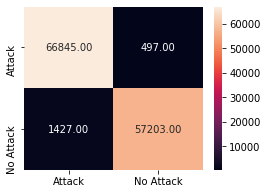

Testing scores
Accuracy score is  0.78
Precision score is 0.91
Recall score is  0.69
F1 score is  0.78
Crossval Score (f1_weighted) 0.95
              precision    recall  f1-score   support

           0       0.69      0.91      0.78      9711
           1       0.91      0.69      0.78     12832

    accuracy                           0.78     22543
   macro avg       0.80      0.80      0.78     22543
weighted avg       0.81      0.78      0.78     22543



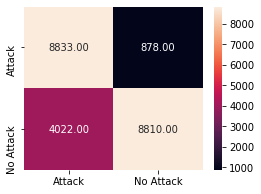

Multiclass Classification
Training scores
              precision    recall  f1-score   support

         Dos       1.00      0.98      0.99     45927
       Probe       0.98      0.97      0.98     11656
         R2L       0.69      0.75      0.72       995
         U2R       0.62      0.35      0.44        52
      normal       0.98      0.99      0.99     67342

    accuracy                           0.98    125972
   macro avg       0.85      0.81      0.82    125972
weighted avg       0.98      0.98      0.98    125972

Crossval Score (f1_weighted) 0.97


Testing scores
              precision    recall  f1-score   support

         Dos       0.89      0.75      0.82      7459
       Probe       0.53      0.55      0.54      2421
         R2L       0.93      0.23      0.36      2885
         U2R       0.83      0.07      0.14        67
      normal       0.68      0.91      0.78      9711

    accuracy                           0.73     22543
   macro avg       0.77      0.50     

In [48]:
model_build_cum_evaluation(rfc, bi_train_x_vif, bi_train_y_vif, bi_test_x_vif, bi_test_y_vif, multi_train_x_vif, multi_train_y_vif, multi_test_x_vif, multi_test_y_vif)

### Gradient Boosting Classifier

In [49]:
gbc = GradientBoostingClassifier()

time: 2.99 ms


Binary Classification
Training scores
Accuracy score is  0.89
Precision score is 0.92
Recall score is  0.83
F1 score is  0.87
Crossval Score (f1_weighted) 0.83
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     67342
           1       0.92      0.83      0.87     58630

    accuracy                           0.89    125972
   macro avg       0.89      0.88      0.89    125972
weighted avg       0.89      0.89      0.89    125972



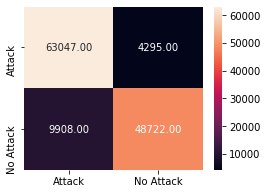

Testing scores
Accuracy score is  0.73
Precision score is 0.93
Recall score is  0.57
F1 score is  0.71
Crossval Score (f1_weighted) 0.73
              precision    recall  f1-score   support

           0       0.63      0.94      0.75      9711
           1       0.93      0.57      0.71     12832

    accuracy                           0.73     22543
   macro avg       0.78      0.76      0.73     22543
weighted avg       0.80      0.73      0.73     22543



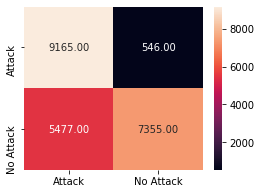

Multiclass Classification
Training scores
              precision    recall  f1-score   support

         Dos       0.00      0.00      0.00     45927
       Probe       0.01      0.01      0.01     11656
         R2L       0.00      0.58      0.01       995
         U2R       0.00      0.04      0.00        52
      normal       0.11      0.00      0.00     67342

    accuracy                           0.01    125972
   macro avg       0.03      0.13      0.01    125972
weighted avg       0.06      0.01      0.00    125972

Crossval Score (f1_weighted) 0.24


Testing scores


C:\Users\chord\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Dos       0.00      0.00      0.00      7459
       Probe       0.31      0.15      0.21      2421
         R2L       0.11      0.75      0.18      2885
         U2R       0.04      0.19      0.07        67
      normal       0.01      0.00      0.00      9711

    accuracy                           0.11     22543
   macro avg       0.09      0.22      0.09     22543
weighted avg       0.05      0.11      0.05     22543

Crossval Score  (f1_weighted) 0.16
time: 28min 43s


In [50]:
model_build_cum_evaluation(gbc, bi_train_x_vif, bi_train_y_vif, bi_test_x_vif, bi_test_y_vif, multi_train_x_vif, multi_train_y_vif, multi_test_x_vif, multi_test_y_vif)

### Logistic Regression

In [51]:
lr = LogisticRegression(n_jobs=-1)

time: 9.8 ms


Binary Classification
Training scores
Accuracy score is  0.92
Precision score is 0.98
Recall score is  0.86
F1 score is  0.91
Crossval Score (f1_weighted) 0.92
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     67342
           1       0.98      0.86      0.91     58630

    accuracy                           0.92    125972
   macro avg       0.93      0.92      0.92    125972
weighted avg       0.93      0.92      0.92    125972



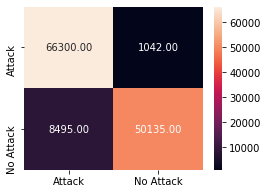

Testing scores
Accuracy score is  0.68
Precision score is 0.91
Recall score is  0.5
F1 score is  0.64
Crossval Score (f1_weighted) 0.84
              precision    recall  f1-score   support

           0       0.58      0.93      0.72      9711
           1       0.91      0.50      0.64     12832

    accuracy                           0.68     22543
   macro avg       0.75      0.71      0.68     22543
weighted avg       0.77      0.68      0.68     22543



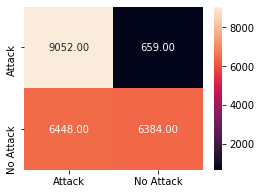

Multiclass Classification
Training scores


C:\Users\chord\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Dos       0.89      0.91      0.90     45927
       Probe       0.72      0.15      0.25     11656
         R2L       0.00      0.00      0.00       995
         U2R       0.00      0.00      0.00        52
      normal       0.87      0.99      0.93     67342

    accuracy                           0.87    125972
   macro avg       0.50      0.41      0.41    125972
weighted avg       0.86      0.87      0.84    125972

Crossval Score (f1_weighted) 0.84


Testing scores


C:\Users\chord\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         Dos       0.76      0.70      0.73      7459
       Probe       0.77      0.06      0.12      2421
         R2L       0.00      0.00      0.00      2885
         U2R       0.00      0.00      0.00        67
      normal       0.59      0.94      0.72      9711

    accuracy                           0.64     22543
   macro avg       0.42      0.34      0.31     22543
weighted avg       0.59      0.64      0.56     22543

Crossval Score  (f1_weighted) 0.71
time: 3min 10s


In [52]:
model_build_cum_evaluation(lr, bi_train_x_vif, bi_train_y_vif, bi_test_x_vif, bi_test_y_vif, multi_train_x_vif, multi_train_y_vif, multi_test_x_vif, multi_test_y_vif)

### Decision Tree 

In [53]:
dt = DecisionTreeClassifier()

time: 3 ms


Binary Classification
Training scores
Accuracy score is  0.98
Precision score is 0.99
Recall score is  0.97
F1 score is  0.98
Crossval Score (f1_weighted) 0.98
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     67342
           1       0.99      0.97      0.98     58630

    accuracy                           0.98    125972
   macro avg       0.99      0.98      0.98    125972
weighted avg       0.98      0.98      0.98    125972



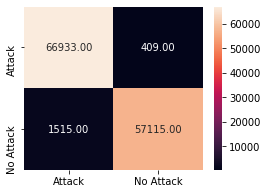

Testing scores
Accuracy score is  0.77
Precision score is 0.91
Recall score is  0.66
F1 score is  0.76
Crossval Score (f1_weighted) 0.95
              precision    recall  f1-score   support

           0       0.67      0.91      0.77      9711
           1       0.91      0.66      0.76     12832

    accuracy                           0.77     22543
   macro avg       0.79      0.79      0.77     22543
weighted avg       0.81      0.77      0.77     22543



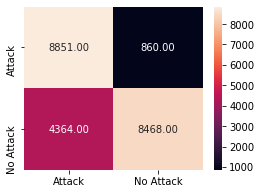

Multiclass Classification
Training scores
              precision    recall  f1-score   support

         Dos       0.99      0.98      0.99     45927
       Probe       0.98      0.98      0.98     11656
         R2L       0.68      0.78      0.72       995
         U2R       0.61      0.38      0.47        52
      normal       0.98      0.99      0.99     67342

    accuracy                           0.98    125972
   macro avg       0.85      0.82      0.83    125972
weighted avg       0.98      0.98      0.98    125972

Crossval Score (f1_weighted) 0.97


Testing scores
              precision    recall  f1-score   support

         Dos       0.90      0.75      0.82      7459
       Probe       0.54      0.56      0.55      2421
         R2L       0.75      0.23      0.36      2885
         U2R       0.71      0.07      0.14        67
      normal       0.68      0.90      0.78      9711

    accuracy                           0.73     22543
   macro avg       0.72      0.51     

In [54]:
model_build_cum_evaluation(dt, bi_train_x_vif, bi_train_y_vif, bi_test_x_vif, bi_test_y_vif, multi_train_x_vif, multi_train_y_vif, multi_test_x_vif, multi_test_y_vif)

### ExtraTree Classifier

In [55]:
et = ExtraTreesClassifier(n_jobs=-1)

time: 5.28 ms


Binary Classification
Training scores
Accuracy score is  0.98
Precision score is 0.99
Recall score is  0.97
F1 score is  0.98
Crossval Score (f1_weighted) 0.98
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     67342
           1       0.99      0.97      0.98     58630

    accuracy                           0.98    125972
   macro avg       0.99      0.98      0.98    125972
weighted avg       0.98      0.98      0.98    125972



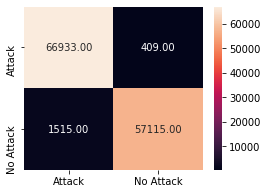

Testing scores
Accuracy score is  0.8
Precision score is 0.91
Recall score is  0.71
F1 score is  0.8
Crossval Score (f1_weighted) 0.95
              precision    recall  f1-score   support

           0       0.70      0.91      0.79      9711
           1       0.91      0.71      0.80     12832

    accuracy                           0.80     22543
   macro avg       0.81      0.81      0.80     22543
weighted avg       0.82      0.80      0.80     22543



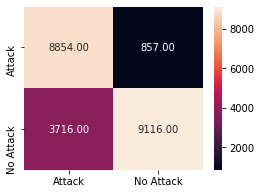

Multiclass Classification
Training scores
              precision    recall  f1-score   support

         Dos       0.99      0.98      0.99     45927
       Probe       0.98      0.98      0.98     11656
         R2L       0.68      0.78      0.72       995
         U2R       0.61      0.38      0.47        52
      normal       0.98      0.99      0.99     67342

    accuracy                           0.98    125972
   macro avg       0.85      0.82      0.83    125972
weighted avg       0.98      0.98      0.98    125972

Crossval Score (f1_weighted) 0.97


Testing scores
              precision    recall  f1-score   support

         Dos       0.89      0.78      0.83      7459
       Probe       0.55      0.60      0.58      2421
         R2L       0.89      0.23      0.37      2885
         U2R       0.83      0.07      0.14        67
      normal       0.70      0.91      0.79      9711

    accuracy                           0.74     22543
   macro avg       0.77      0.52     

In [56]:
model_build_cum_evaluation(et, bi_train_x_vif, bi_train_y_vif, bi_test_x_vif, bi_test_y_vif, multi_train_x_vif, multi_train_y_vif, multi_test_x_vif, multi_test_y_vif)

Best weighted f1 score for test was achieved by
Random Forest Classifier, Decision Tree and Extra Tree Classifier. The results were same.
From above 3 we'll select Decision Tree as best model as time taken for execution by it was the least 1 min 6 seconds.